In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

In [17]:
k = 1.38064852e-23    # m^2 kg s^-2 K^-1, Boltzmann's constant
h = 6.62607004e-34    # m^2 kg s^-1     , Planck's constant
c = 2.99792458e8      # m s^-1          , speed of light
eV = 1.6021766208e-19 # joule           , eV to joule
q = 1.6021766208e-19  # C               , elemental charge

In [18]:
ref_solar_irradiance = np.loadtxt("AM1_5G_solar_irradiance.csv", delimiter=",", skiprows=1)

In [19]:
WL, solar_per_nm = ref_solar_irradiance[:, 1], ref_solar_irradiance[:, 3]
E = (h * c * 1e9) / (eV * WL) # nm to eV
solar_per_E = solar_per_nm * (eV / 1e-9) * h * c / (eV * E)**2 # jacobian transformation, W m^-2 eV^-1

In [20]:
Es = np.arange(0.32, 4.4, 0.002)
# linear interpolation to get an equally spaced spectrum
solar_per_Es = np.interp(Es, E, solar_per_E)  # W m^-2 eV^-1
solar_flux = solar_per_Es / (Es * eV)  # number of photon m^-2 eV^-1 s^-1

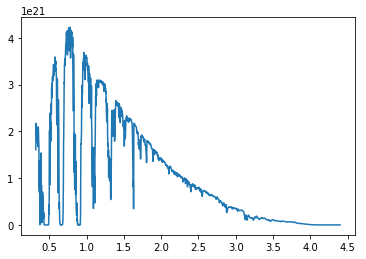

In [21]:
plt.plot(Es, solar_flux)
plt.show()

In [22]:
T=300
EQE_EL=1.0
intensity=1.0

In [23]:
# Calculate Jsc
solar_flux_cumm = cumtrapz(solar_flux[::-1], Es[::-1], initial=0)
solar_flux_aboveE = solar_flux_cumm[::-1] * -1 * intensity
Jsc = solar_flux_aboveE * q * 0.1  # mA/cm^2  (0.1: from A/m2 to mA/cm2)

In [24]:
# Calculate J0
bb_phi_T = 2 * np.pi * (((Es * eV)**2) * eV / ((h**3) * (c**2)) / (
                           np.exp(Es * eV / (k * T)) - 1))

bb_flux_cumm = cumtrapz(bb_phi_T[::-1], Es[::-1], initial=0)
bb_flux_aboveE = bb_flux_cumm[::-1] * -1
J0 = bb_flux_aboveE * q * 0.1 / EQE_EL  # (0.1: from A/m2 to mA/cm2)
J0[-1] = np.nan  # avoid divide by zero when calculating Voc

In [25]:
# Calculate Voc
Voc = (k * T / q) * np.log((Jsc/J0) + 1)

In [26]:
PCE = []
for i, E in enumerate(Es):
    V = np.arange(0, E, 0.001)  # can change upperbound to Voc
    J = -1 * Jsc[i] + J0[i] * (
        np.exp(q * V / (k * T)) - 1)
    PCE.append(-1 * np.min(J * V) / intensity)

In [27]:
# Calculate FF
FF = PCE / (Voc * Jsc) * 100.0 * intensity

In [28]:
def get_params(Eg, toPrint=True):
    '''
    input Eg, return or print the corresponding parameters
    if toPrint == True : print the result, return nothing
    if toPrint == False: return the result as a dictionary
    '''

    if not Es[0] <= Eg <= Es[-1]:
        print("invalid bandgap \nvalid range: 0.32 to 4.4")
        return
    params = {}
    # could change these to binary search
    params["Voc"] = np.interp([Eg], Es, Voc)[0]
    params["Jsc"] = np.interp([Eg], Es, Jsc)[0]
    params["FF"] = np.interp([Eg], Es, FF)[0]
    params["PCE"] = np.interp([Eg], Es, PCE)[0]
    params["J0"] = np.interp([Eg], Es, J0)[0]

    if toPrint:  # won't return anything; print in console instead
        print()
        print("Bandgap: {0:.3f} eV \n".format(Eg))
        print("J0 = {0:.3g} mA/cm^2".format(params["J0"]))
        print("Voc = {0:.4g} \t V".format(params["Voc"]))
        print("Jsc = {0:.4g} \t mA/cm^2".format(params["Jsc"]))
        print("FF  = {0:.2f} \t %".format(params["FF"]))
        print("PCE = {0:.3f} \t %".format(params["PCE"]))
    
    return params


Bandgap: 1.340 eV 

J0 = 2.36e-17 mA/cm^2
Voc = 1.082 	 V
Jsc = 35.04 	 mA/cm^2
FF  = 88.90 	 %
PCE = 33.694 	 %


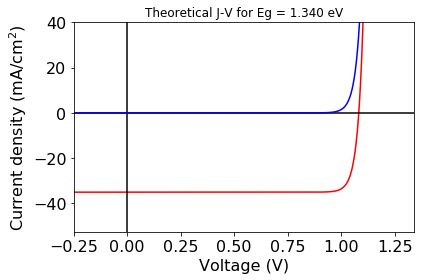

In [29]:
# Simulate JV curve
Eg = 1.34
Vstep=0.001
Vmin=-0.5

V = np.arange(Vmin, Eg, Vstep)
params = get_params(Eg)
J0, Jsc = params["J0"], params["Jsc"]

J = -1.0 * Jsc + J0 * (np.exp(q * V / (k * T)) - 1)
Jdark = J + Jsc
mask = (J <= 200)
# to do:
# could modify the method to take xlim, ylim as inputs
# move 'title' into the figure and add add Voc Jsc FF, PCE to it
title = "Theoretical J-V for Eg = {:.3f} eV".format(Eg)
# plt.figure()
plt.plot(V[mask], J[mask], 'r')
plt.plot([-1, Eg], [0, 0], 'k')
plt.plot([0, 0], [-2 * Jsc, 200], 'k')
plt.plot(V[mask], Jdark[mask], 'b')
plt.ylim(-1.5 * Jsc, min(40, 1.5 * Jsc))
plt.xlim(-0.25, Eg)
plt.xlabel("Voltage (V)", fontsize=16)
plt.ylabel("Current density (mA/$\mathregular{cm^2}$)",
           fontsize=16)
plt.tick_params(labelsize=16)
plt.title(title)
plt.tight_layout()